In [7]:
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

sns.set(rc={"figure.figsize": (8,4)})
pd.set_option("display.max_colwidth", 200)


In [8]:
df = pd.read_csv(
    r"C:\Users\Kerem Gülser\Desktop\Dersler\Son Dönem\Natural Language Processing\Dynamically Generated Hate Dataset v0.2.3.csv",
    encoding="utf-8"
)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (41144, 13)


,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,1,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,2,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,3,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,4,acl1000,4,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,5,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [9]:
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      41144 non-null  int64 
 1   acl.id          41144 non-null  object
 2   X1              41144 non-null  int64 
 3   text            41144 non-null  object
 4   label           41144 non-null  object
 5   type            41144 non-null  object
 6   target          41136 non-null  object
 7   level           41144 non-null  object
 8   split           41144 non-null  object
 9   round.base      41144 non-null  int64 
 10  annotator       41144 non-null  object
 11  round           41144 non-null  object
 12  acl.id.matched  30098 non-null  object
dtypes: int64(3), object(10)
memory usage: 4.1+ MB

Missing values per column:
Unnamed: 0            0
acl.id                0
X1                    0
text                  0
label                 0
type                  0
target  

In [12]:
print("Columns:", df.columns.tolist())


Columns: ['Unnamed: 0', 'acl.id', 'X1', 'text', 'label', 'type', 'target', 'level', 'split', 'round.base', 'annotator', 'round', 'acl.id.matched']


In [14]:
# Identify columns
text_col = "text"
label_col = "label"

import re
import emoji

url_pat = re.compile(r"http\S+|www\.\S+")
mention_pat = re.compile(r"@\w+")
hashtag_pat = re.compile(r"#")
non_letter = re.compile(r"[^a-zA-Z\s]")

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = url_pat.sub(" ", text)
    text = mention_pat.sub(" ", text)
    text = hashtag_pat.sub("", text)
    text = text.lower()
    text = non_letter.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df[text_col].apply(clean_text)
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
df[["clean_text", "word_count"]].head()


,clean_text,word_count
0,dalits are lowlives,3
1,gay people are a burden to our society,8
2,arabs are not welcome,4
3,i m not saying we should actually eliminate heebs i just wish they naturally became extinct,16
4,bananas are for black people,5


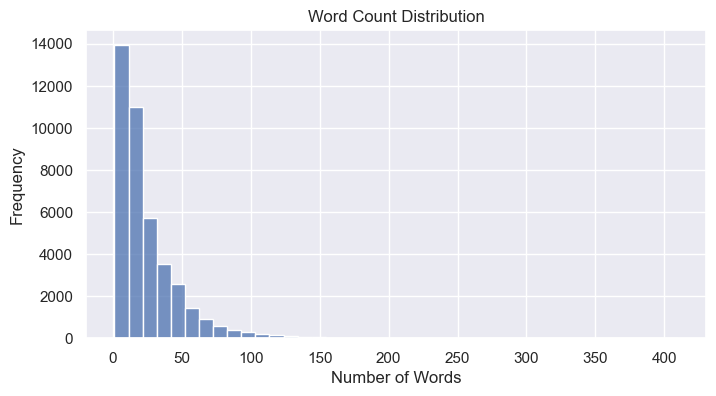

Empty text count: 0
Average word count: 24.95
Median word count: 17.0


In [15]:
sns.histplot(df["word_count"], bins=40)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print("Empty text count:", (df["clean_text"] == "").sum())
print("Average word count:", df["word_count"].mean().round(2))
print("Median word count:", df["word_count"].median())


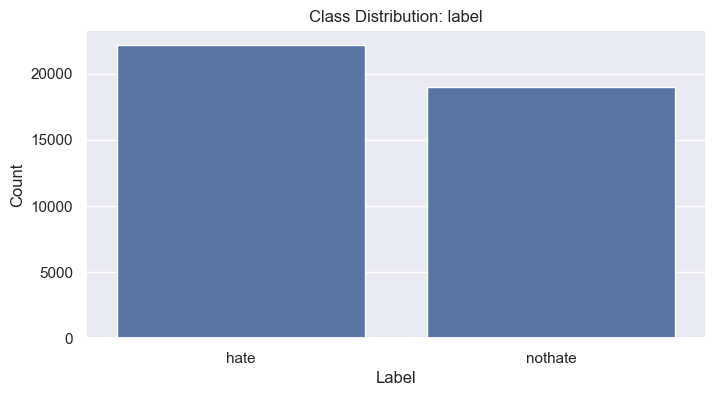

label
hate       22175
nothate    18969
Name: count, dtype: int64


In [16]:
if label_col in df.columns:
    sns.countplot(x=label_col, data=df)
    plt.title(f"Class Distribution: {label_col}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

    print(df[label_col].value_counts())


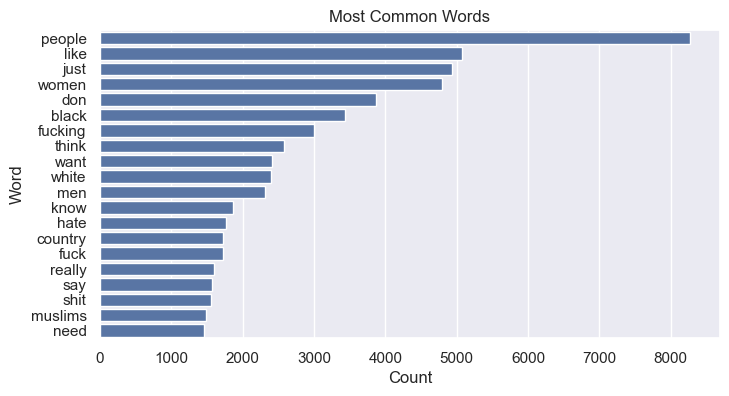

In [17]:
cv = CountVectorizer(stop_words="english", max_features=20)
X = cv.fit_transform(df["clean_text"])
words = cv.get_feature_names_out()
word_freq = np.array(X.sum(axis=0)).flatten()

freq_df = pd.DataFrame({"word": words, "count": word_freq}).sort_values(by="count", ascending=False)

sns.barplot(x="count", y="word", data=freq_df)
plt.title("Most Common Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


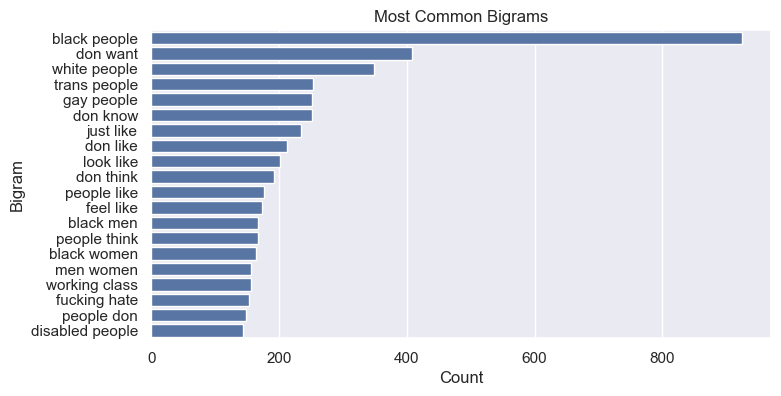

In [18]:
cv_bi = CountVectorizer(stop_words="english", ngram_range=(2,2), max_features=20)
X_bi = cv_bi.fit_transform(df["clean_text"])
bigrams = cv_bi.get_feature_names_out()
bigram_freq = np.array(X_bi.sum(axis=0)).flatten()

freq_bi = pd.DataFrame({"bigram": bigrams, "count": bigram_freq}).sort_values(by="count", ascending=False)

sns.barplot(x="count", y="bigram", data=freq_bi)
plt.title("Most Common Bigrams")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.show()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# TF-IDF features
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df[label_col],
                                                    test_size=0.2, random_state=42)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Baselines
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "NaiveBayes": MultinomialNB(),
    "SVM": LinearSVC()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred, average="macro"), 3)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("F1-score:", f1)




LogisticRegression
Accuracy: 0.671
F1-score: 0.668

NaiveBayes
Accuracy: 0.634
F1-score: 0.625

SVM
Accuracy: 0.659
F1-score: 0.656


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 5, 10],
    "penalty": ["l2"],
    "max_iter": [300, 500]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train_tfidf, y_train)

print("Best LR Params:", grid_lr.best_params_)
print("Best LR Mean F1:", round(grid_lr.best_score_, 3))


Best LR Params: {'C': 1, 'max_iter': 300, 'penalty': 'l2'}
Best LR Mean F1: 0.661


In [23]:
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

print("Optimized LR Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("Optimized LR F1:", round(f1_score(y_test, y_pred_lr, average='macro'), 3))


Optimized LR Accuracy: 0.671
Optimized LR F1: 0.668


In [24]:
param_grid_svm = {
    "C": [0.01, 0.1, 1, 5, 10]
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_svm.fit(X_train_tfidf, y_train)

print("Best SVM Params:", grid_svm.best_params_)
print("Best SVM Mean F1:", round(grid_svm.best_score_, 3))


Best SVM Params: {'C': 0.1}
Best SVM Mean F1: 0.66


In [25]:
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_tfidf)

print("Optimized SVM Accuracy:", round(accuracy_score(y_test, y_pred_svm), 3))
print("Optimized SVM F1:", round(f1_score(y_test, y_pred_svm, average='macro'), 3))


Optimized SVM Accuracy: 0.668
Optimized SVM F1: 0.665


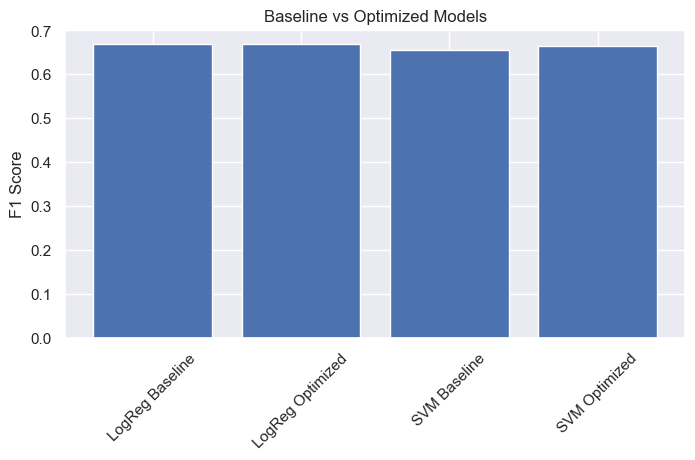

In [30]:
models = ["LogReg Baseline", "LogReg Optimized", "SVM Baseline", "SVM Optimized"]
scores = [0.668, lr_optimized_f1, 0.656, svm_optimized_f1]

plt.bar(models, scores)
plt.ylabel("F1 Score")
plt.title("Baseline vs Optimized Models")
plt.xticks(rotation=45)
plt.show()
